In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip

['Archive:  fra-eng.zip',
 '  inflating: _about.txt              ',
 '  inflating: fra.txt                 ']

In [4]:
batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "fra.txt"

In [5]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [6]:
input_texts[0:3], target_texts[0:3]

(['Go.', 'Go.', 'Go.'], ['\tVa !\n', '\tMarche.\n', '\tBouge !\n'])

In [7]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [45]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

encoder_input_data.shape, decoder_input_data.shape, decoder_target_data.shape

((10000, 15, 71), (10000, 59, 93), (10000, 59, 93))

In [49]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
          
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
  
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0 # !!!  t + 1 : keep fill till end
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0 # !! t :  keep fill till end
    

In [52]:
for i in range(10):
  print(i)

print("i : ",i) # --> that is different than for(i=0;i<10;i++) then print(i) 

0
1
2
3
4
5
6
7
8
9
i :  9


### decoder_input : \t x y z t n 'space' 'space' ....
### decoder_target : x y z t n 'space' 'space' ...

In [10]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 lstm[0][1]                   

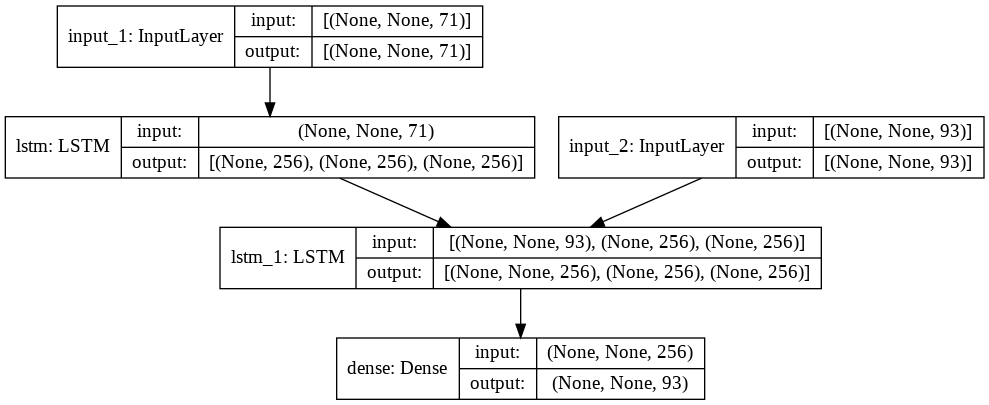

In [12]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)


### split in fit no need for sklearn or pandas

In [13]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")

Epoch 1/50
125/125 [==============================] - 36s 19ms/step - loss: 1.5001 - accuracy: 0.7023 - val_loss: 1.0510 - val_accuracy: 0.7103
Epoch 2/50
125/125 [==============================] - 1s 12ms/step - loss: 0.8671 - accuracy: 0.7645 - val_loss: 0.8249 - val_accuracy: 0.7724
Epoch 3/50
125/125 [==============================] - 1s 12ms/step - loss: 0.7033 - accuracy: 0.8032 - val_loss: 0.7066 - val_accuracy: 0.7934
Epoch 4/50
125/125 [==============================] - 1s 12ms/step - loss: 0.5925 - accuracy: 0.8287 - val_loss: 0.6300 - val_accuracy: 0.8169
Epoch 5/50
125/125 [==============================] - 1s 12ms/step - loss: 0.5314 - accuracy: 0.8444 - val_loss: 0.5974 - val_accuracy: 0.8260
Epoch 6/50
125/125 [==============================] - 1s 12ms/step - loss: 0.4950 - accuracy: 0.8544 - val_loss: 0.5635 - val_accuracy: 0.8352
Epoch 7/50
125/125 [==============================] - 1s 12ms/step - loss: 0.4656 - accuracy: 0.8623 - val_loss: 0.5487 - val_accuracy: 0.839

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


In [17]:
model.layers

In [16]:
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

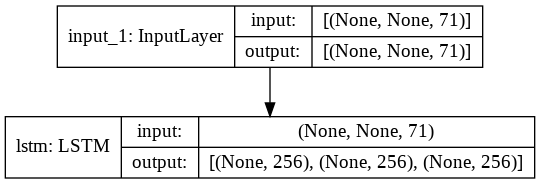

In [18]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(encoder_model, show_shapes=True, show_layer_names=True)


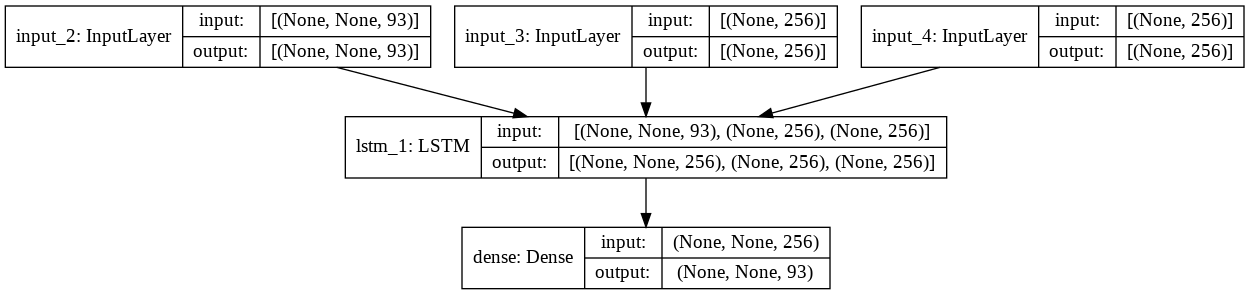

In [19]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(decoder_model, show_shapes=True, show_layer_names=True)


In [29]:
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    print("input_seq : ",input_seq)
    states_value = encoder_model.predict(input_seq)
    #print("statue_value : ",states_value)
    print("output of encoder len : ",len(states_value))
    print("output of encoder 0 shape : ",states_value[0].shape)


    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens)) # single letter --> \t
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0 # --> start with dummy letter

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [35]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    input_seq2 = encoder_input_data[seq_index+10 : seq_index + 11]
    two_sentence = np.concatenate([input_seq,input_seq2],axis=1)

    decoded_sentence = decode_sequence(two_sentence)
    print("-")
    print("Input sentence:", input_texts[seq_index]+input_texts[seq_index+10])
    print("Decoded sentence:", decoded_sentence+"after") # it comes with \n

    # two sentence break models
    break

input_seq :  [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]
output of encoder len :  2
output of encoder 0 shape :  (1, 256)
-
Input sentence: Go.Run!
Decoded sentence: Enouvez à m'ai eu tien !
after
